In [1]:
library(fpp2)
library(forecast)
library(rugarch)

data <- read.csv('../data/data_up.csv', sep=';')

vett_prices <- as.vector(t(c(data[,2:25])))
vett_volumes <- c(data[,26:49])

###
factor <- '.'
for (i in 1:8030){
  if (nchar(as.character(vett_prices[[2]])[i])>6){
    factor <- as.character(vett_prices[[2]])[i]
    counter <- 0
    j <- 1
    while (counter<2){
      if (substr(factor, start=j, stop=j)=='.'){
        counter = counter+1
      }
      j <- j+1
    }
    levels(vett_prices[[2]]) <- c(levels(vett_prices[[2]]), substr(factor, start=1, stop=j-2))
    vett_prices[[2]][[i]] <- substr(factor, start=1, stop=j-2)
    print(vett_prices[[2]][[i]])
  }
}

numeric_vec <- as.numeric(as.character(vett_prices[[2]]))
vett_prices[[2]] <- numeric_vec
###

matrix_prices <- t(do.call(cbind, vett_prices))
matrix_volumes <- t(do.call(cbind, vett_volumes))

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ────────────────────────────────────────────── fpp2 2.5 ──

✔ ggplot2   3.5.0      ✔ fma       2.5   
✔ forecast  8.22.0     ✔ expsmooth 2.3   



Caricamento del pacchetto richiesto: parallel


Caricamento pacchetto: ‘rugarch’


Il seguente oggetto è mascherato da ‘package:stats’:

    sigma




[1] "24.005"
[1] "8.396"
[1] "16.560"
[1] "12.885"
[1] "60.245"


In [2]:
scalar_prices <- c(matrix_prices)
print(scalar_prices[12:28])
scalar_volumes <- c(matrix_volumes)
print(scalar_volumes[12:28])

st_prices <- ts(scalar_prices)
window_prices <- window(st_prices, end=24*731)

st_volumes <- ts(scalar_volumes)
window_volumes <- window(st_volumes, start=1, end=24*731)

dates <- seq(from = as.POSIXct("2000-01-01 01:00:00", format = "%Y-%m-%d %H:%M:%S"),
             to = as.POSIXct("2002-01-01 00:00:00", format = "%Y-%m-%d %H:%M:%S"),
             by = "hour")

df_dates <- data.frame(colonna1=c(dates), colonna2=window_prices, colonna3=window_volumes)
st_prices <- ts(df_dates[,2], start=c(2000,1), end=c(2002,1), frequency=24*365)
st_volumes <- ts(df_dates[,3], start=c(2000,1), end=c(2002,1), frequency=24*365)

st_prices <- window(st_prices, start=c(2001,1), end=c(2002,1), frequency=24*365)
st_volumes <- window(st_volumes, start=c(2001,1), end=c(2002,1), frequency=24*365)

#correlation between variables
df <- data.frame(colonna1=scalar_prices, colonna2=scalar_volumes)


 [1] 21.50 21.51 21.59 21.50 21.75 27.02 28.57 27.48 27.48 24.23 27.31 21.50
[13] 15.13 11.67  5.90  5.90  5.85
 [1] 5803 5909 5959 5914 5981 6221 6505 6485 6379 6213 6165 6033 5790 5571 5431
[16] 5342 5309


[1] 192720

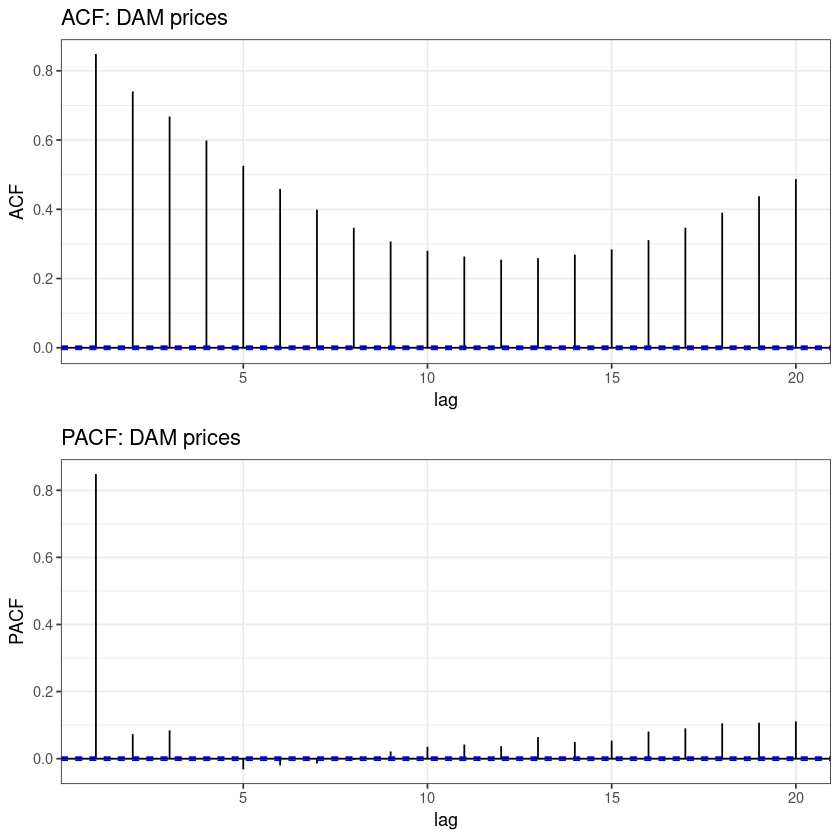

In [4]:
#ACF
st_prices <- ts(df_dates[,2], start=c(2000,1), end=c(2021,365*24), frequency=24*365)
p1 <- ggAcf(st_prices, lag.max=20) +
      labs(x = 'lag', title = 'ACF: DAM prices') +
      theme_bw()
#PACF
p2 <- ggPacf(st_prices, lag.max=20) +
      labs(x = 'lag', title = 'PACF: DAM prices') +
      theme_bw()
gridExtra::grid.arrange(p1, p2, ncol = 1)
length(st_prices)

In [4]:
tt <- 192720*0.8
t <- 219
arima_fit <- auto.arima(window(st_prices ,end=c(2017,t), frequency=365*24), seasonal = TRUE)#, seasonal = FALSE)
arima_fit

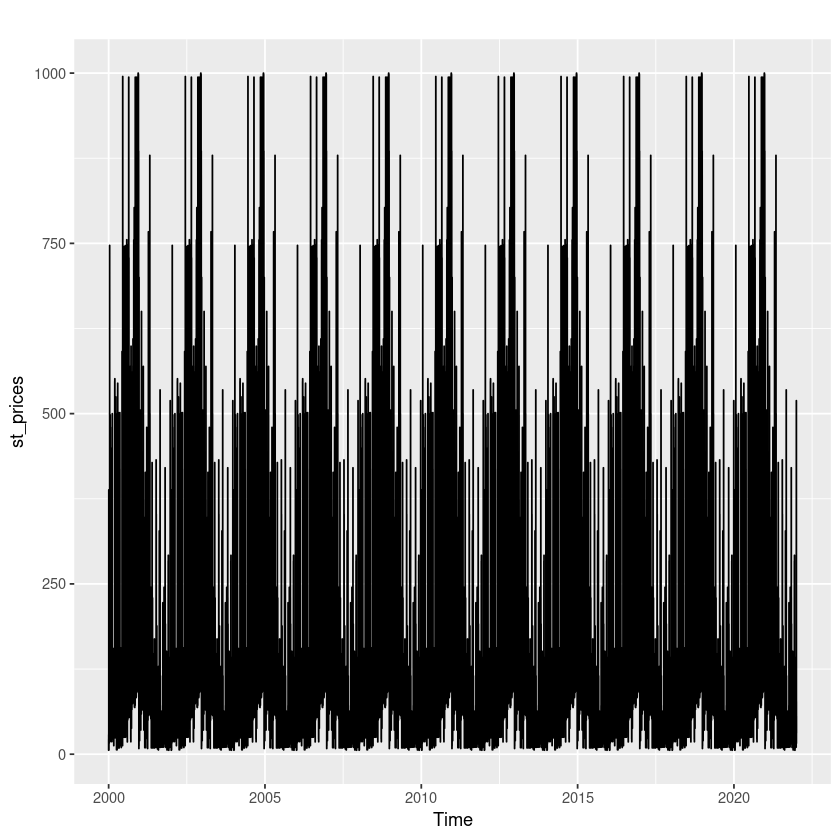

In [92]:
autoplot(st_prices)

In [44]:
365*17+4-6424

[1] -215

In [46]:
#
#naive
#
naive_train <- fitted(naive(st_prices))

resi_naive <- window(st_prices,start=c(2000,4),frequency=365*24)-window(naive_train,start=c(2000,4),frequency=365*24)
mse_naive_test <- mean(window(resi_naive, start=c(2017,t+1), frequency=365*24)^2)
mse_naive_train <- mean(window(resi_naive, end=c(2017,t), frequency=365*24)^2)
mae_naive_train <- mean(abs(window(resi_naive, end=c(2017,t), frequency=365*24)))
mae_naive_test <- mean(abs(window(resi_naive, start=c(2017,t+1), frequency=365*24)))

#naive_train <- ts(naive_train, start=c(2000,4), end=c(2021,365*24), frequency=365*24)
st_naive<-window(naive_train, start=c(2018,100), end=c(2018,250), frequency=365*24)
res_naive<-window(resi_naive, start=c(2018,100), end=c(2018,250), frequency=365*24)


In [13]:
###
# ARIMA FORCED TO AR
###
p<-3
tt <- 192720*0.8
t <- 7009
t <- 219
endd<-160
model <- Arima(window(st_prices ,end=c(2017,t), frequency=365*24), order=c(p,0,0))
fitted <- rep(0,length(st_prices))
for (i in 4:length(st_prices)){
  fitted[i] <- as.numeric(model$coef[3])*st_prices[i-3]+
               as.numeric(model$coef[2])*st_prices[i-2]+
               as.numeric(model$coef[1])*st_prices[i-1]+
               as.numeric(model$coef[4])*(1-as.numeric(model$coef[1])-
                                          as.numeric(model$coef[2])-
                                          as.numeric(model$coef[3]))
}
res_fitted <- st_prices[4:length(st_prices)]-fitted[4:length(st_prices)]
fitted_train <- fitted[4:tt]
fitted_train <- ts(fitted_train, start=c(2000,4), frequency=365*24)
forecast <- ts(fitted[(tt+1):192720], start=c(2017,t+1), frequency=365*24)
mse_arima_train <- mean(res_fitted[1:(tt-3)]^2)
mse_arima_test <- mean(res_fitted[(tt-2):(length(st_prices)-3)]^2)
mae_arima_train <- mean(abs(res_fitted[1:(tt-3)]))
mae_arima_test <- mean(abs(res_fitted[(tt-2):(length(st_prices)-3)]))
arima_model <- ts(c(as.vector(fitted_train), as.vector(forecast)),
                  start=c(2000,4), frequency=365*24)
res_fitted <- ts(res_fitted, start=c(2000,4), frequency=365*24)
res_fitted <- window(res_fitted, start=c(2018,100), end=c(2018,250), frequency=365*24)
models_arima <- ts(data.frame(y1=window(st_prices, start=c(2018,100), end=c(2018,250), frequency=365*24),
                              y2=window(arima_model, start=c(2018,100), end=c(2018,250), frequency=365*24),
                              y3=st_naive),
                   start=c(2018,100), end=c(2018,250), frequency=365*24)

p1<-autoplot(models_arima) +
  labs(title = paste("AR(",p,")", sep = ""), x = "time (hours)", y = "prices", color = "") +
  scale_color_manual(values = c("black", "red","blue"),
                     labels = c("Ground truth", paste("AR(",p,")", sep = ""), "Naive")) +
  scale_x_continuous(breaks = seq(2018, 2019, by = 1/(12*30))) +
  theme(axis.text.x = element_blank(),    # Rimuove le etichette sull'asse x
        axis.title.x = element_text(size = 10), # Mantiene il titolo se necessario
        axis.ticks.x = element_line()) +   # Mantiene i tick
  theme_bw()
#ses plot residuals
p2 <- autoplot(ts(data.frame(y1=res_fitted,
                             y2=res_naive),
                   start=c(2018,100), end=c(2018,250), frequency=365*24)) +
  labs(title='Residuals', x = "time (hours)", y = "residuals", color = "") +
  scale_color_manual(values = c("red", "blue"), ,
                     labels = c("AR(3)            ","Naive")) +
  ylim(-42,33) +
  scale_x_continuous(breaks = seq(2018, 2019, by = 1/(12*30))) +
  theme(axis.text.x = element_blank(),    # Rimuove le etichette sull'asse x
        axis.title.x = element_text(size = 10), # Mantiene il titolo se necessario
        axis.ticks.x = element_line()) +   # Mantiene i tick
  theme_bw()

png("ar3.png", width = 1000, height = 600, res = 100)  # Altezza/larghezza in pixel
gridExtra::grid.arrange(p1, p2, ncol = 1)
dev.off()


png 
  2

In [141]:
length(window(st_prices, start=c(2000,4), frequency=365*24))
length(st_prices)
8030*.8
6424/365
150/24

[1] 192717

[1] 192720

[1] 6424

[1] 17.6

[1] 6.25

In [14]:
mae_naive_train
mae_naive_test

[1] 4545.867

[1] 3723.852

In [15]:
mse_arima_train
mse_arima_test

[1] 4056.542

[1] 3670.731

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


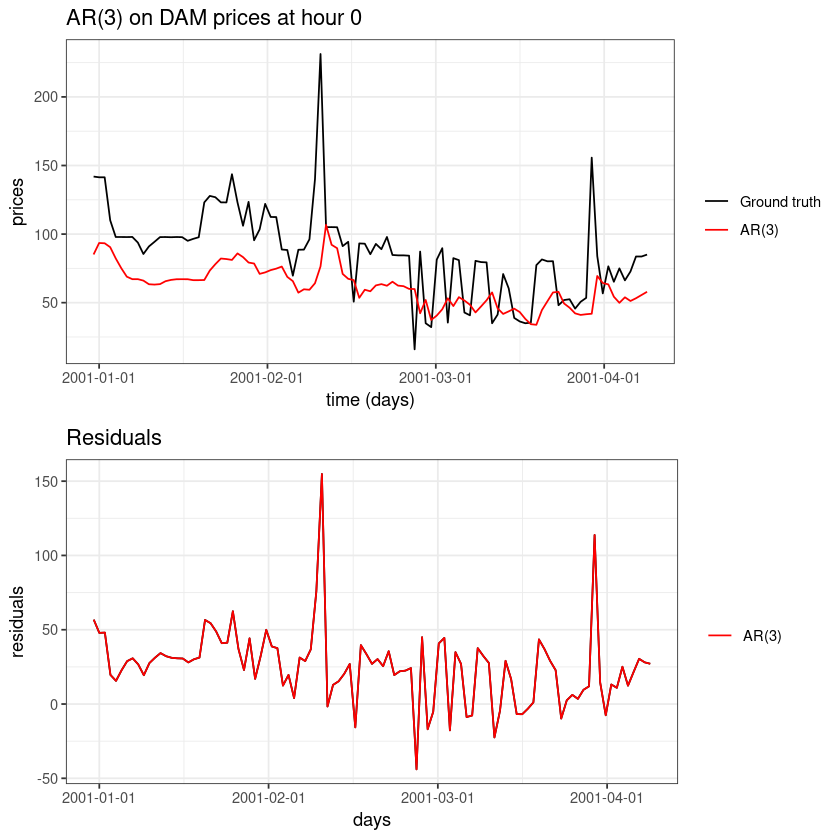

In [9]:
###
# ARIMA FORCED TO AR APPLIED TO DAILY SERIES
###
p<-3
t <- 7009
endd<-100
hour0 <- ts(matrix_prices[1,362:dim(matrix_prices)[2]], start=c(2000,362), frequency=365)
model <- Arima(hour0, order=c(p,0,0))
fitted <- rep(0,length(hour0))
for (i in 4:length(hour0)){
  fitted[i] <- as.numeric(model$coef[3])*hour0[i-3]+
    as.numeric(model$coef[2])*hour0[i-2]+
    as.numeric(model$coef[1])*hour0[i-1]+
    as.numeric(model$coef[4])*(1-as.numeric(model$coef[1])-
                                 as.numeric(model$coef[2])-
                                 as.numeric(model$coef[3]))
}
res_fitted = hour0[4:length(hour0)]-fitted[4:length(hour0)]
fitted <- fitted[4:length(hour0)]
fitted <- ts(fitted, start=c(2000,365), frequency=365)
mse_arima_train <- mean(res_fitted^2)
res_fitted <- ts(res_fitted, start=c(2000,365), end=c(2001,endd), frequency=365)
models_arima <- ts(data.frame(y1=window(hour0, start=c(2000,365), end=c(2001,endd), frequency=365),
                              y2=window(fitted, end=c(2001,endd), frequency=365)),
                   start=c(2000,365), end=c(2001,endd), frequency=365)

p1<-autoplot(models_arima) +
  labs(title = paste("AR(",p,") on DAM prices at hour 0", sep = ""), x = "time (days)", y = "prices", color = "") +
  scale_color_manual(values = c("black", "red"),
                     labels = c("Ground truth", paste("AR(",p,")", sep = ""))) +
  scale_x_continuous(breaks=seq(2001,2002,by=1/12), labels=seq(from = as.Date("2001/01/01"),
                                                                    to = as.Date("2002/01/01"),
                                                                    by = "month")) +
  theme_bw()
#ses plot residuals
p2 <- autoplot(res_fitted) +
  labs(title='Residuals', x = "days", y = "residuals", color = "") +
  scale_color_manual(values = c('AR(3)            ' = "red")) +
  geom_line(aes(colour = 'AR(3)            ')) +  # Aggiungo una mappatura del colore
  scale_x_continuous(breaks=seq(2001,2002,by=1/12), labels=seq(from = as.Date("2001/01/01"),
                                                               to = as.Date("2002/01/01"),
                                                               by = "month")) +
  theme_bw()
#grid with forecasts and corresponding residuals
gridExtra::grid.arrange(p1, p2, ncol = 1)

#

In [41]:
hour4 <- ts(matrix_prices[1,90:dim(matrix_prices)[2]], start=c(2000,90), frequency=365)
length(window(hour4, end=c(2017,236)))
8030-90
7940*0.8
dim(matrix_prices)[2]

[1] 6352

[1] 7940

[1] 6352

[1] 8030

In [98]:
h <- 2021
d1 <- 266
d2 <- 315
h <- 2018
d1 <- 100
d2 <- 250
t <- 6349
p <- 3
#hour4 <- ts(matrix_prices[1,362:dim(matrix_prices)[2]], start=c(2000,362), frequency=365)
hour4 <- ts(matrix_prices[1,90:dim(matrix_prices)[2]], start=c(2000,90), frequency=365)
model <- Arima(window(hour4, end=c(2017,236)), order=c(p,0,0))
fitted <- rep(0,length(hour4))
for (i in 4:length(hour4)){
  fitted[i] <- as.numeric(model$coef[3])*hour4[i-3]+
    as.numeric(model$coef[2])*hour4[i-2]+
    as.numeric(model$coef[1])*hour4[i-1]+
    as.numeric(model$coef[4])*(1-as.numeric(model$coef[1])-
                                 as.numeric(model$coef[2])-
                                 as.numeric(model$coef[3]))
}
res_fitted = hour4[4:length(hour4)]-fitted[4:length(hour4)]
fitted <- fitted[4:length(hour4)]
fitted <- ts(fitted, start=c(2000,93), frequency=365)####
#mse_arima_train <- mean(window(res_fitted, end=c(2017,236))^2)
#abs_fitted <- abs(res_fitted)
#mae_ar_test <- mean(abs_fitted[(t+1):(length(hour4)-3)])
res_fitted <- ts(res_fitted, start=c(2000,93), frequency=365)####
models_arima <- ts(data.frame(y1=window(hour4, start=c(h,d1), end=c(h,d2), frequency=365),
                              y2=window(fitted, start=c(h,d1), end=c(h,d2), frequency=365),
                              y3=window(st_var, start=c(h,d1), end=c(h,d2))),
                   start=c(h,d1), end=c(h,d2), frequency=365)
res_arima_focus <- window(res_fitted, start=c(h,d1), end=c(h,d2))

p1<-autoplot(models_arima) +
  labs(title = paste("AR(",p,") and VAR(3) on DAM prices at hour 0", sep = ""), x = "time (days)", y = "prices", color = "") +
  scale_color_manual(values = c("black", "red", "blue"),
                     labels = c("Ground truth", paste("AR(",p,")", sep = ""), "VAR(3)")) +
  scale_x_continuous(breaks=seq(2018,2019,by=1/12), labels=seq(from = as.Date("2018/01/01"),
                                                               to = as.Date("2019/01/01"),
                                                               by = "month")) +
  theme_bw()
#ses plot residuals
p2 <- autoplot(ts(data.frame(y1=window(res_arima_focus, start=c(h,d1), end=c(h,d2), frequency=365),
                             y2=res_fitted_focus),#VAR
                   start=c(h,d1), end=c(h,d2), frequency=365)) +
  labs(title='Residuals', x = "time (days)", y = "residuals", color = "") +
  scale_color_manual(values = c("red", "blue"), labels = c("AR(3)", "VAR(3)          ")) +
  scale_x_continuous(breaks=seq(2018,2019,by=1/12), labels=seq(from = as.Date("2018/01/01"),
                                                               to = as.Date("2019/01/01"),
                                                               by = "month")) +
  theme_bw()
#grid with forecasts and corresponding residuals
png("vec.png", width = 1000, height = 600, res = 100)  # Altezza/larghezza in pixel
gridExtra::grid.arrange(p1, p2, ncol = 1)
dev.off()


png 
  2

In [7]:
# MAE

h <- 2021
d1 <- 266
d2 <- 315
p <- 3
mse_arima_test = rep(0,24)
mae_ar_test = rep(0,24)
mse_arima_train <- mse_arima_test
mae_ar_train <- mae_ar_test
for (z in 1:24){
  hour <- ts(matrix_prices[z,90:dim(matrix_prices)[2]], start=c(2000,90), frequency=365)
  hour_train <- window(hour, end=c(2017,237))
  model <- Arima(hour_train, order=c(p,0,0))
  fitted1 <- rep(0,length(hour))
  for (i in 4:length(hour)){
    fitted1[i] <- as.numeric(model$coef[3])*hour[i-3]+
      as.numeric(model$coef[2])*hour[i-2]+
      as.numeric(model$coef[1])*hour[i-1]+
      as.numeric(model$coef[4])*(1-as.numeric(model$coef[1])-
                                   as.numeric(model$coef[2])-
                                   as.numeric(model$coef[3]))
  }
  fitted1 = fitted1[4:length(hour)]
  res_fitted1 = hour[4:length(hour)]-fitted1
  res_ts1 <- ts(res_fitted1, start=c(2000,93), frequency=365)
  mse_arima_test[z] <- mean(window(res_ts1, start=c(2017,238))^2)
  mse_arima_train[z] <- mean(window(res_ts1, end=c(2017,237))^2)
  abs_fitted1 <- abs(res_ts1)
  mae_ar_test[z] <- mean(window(abs_fitted1, start=c(2017,238)))
  mae_ar_train[z] <- mean(window(abs_fitted1, end=c(2017,237)))
}


In [10]:
mean(mae_ar_test)
mean(mae_ar_train)
mean(mse_arima_test)
mean(mse_arima_train)

[1] 35.39699

[1] 38.19079

[1] 8404.054

[1] 8486.924

In [31]:
spec = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)), mean.model=list(armaOrder=c(p,0)))
garch_AR3 <- ugarchfit(spec=spec, data=res_fitted1)
print(garch_AR3)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(3,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
         Estimate  Std. Error  t value Pr(>|t|)
mu      -1.999470    1.689440  -1.1835 0.236607
ar1      0.042498    0.017129   2.4810 0.013101
ar2      0.110130    0.018005   6.1167 0.000000
ar3      0.053084    0.017933   2.9601 0.003075
omega  321.704684   23.447463  13.7202 0.000000
alpha1   0.093928    0.006081  15.4468 0.000000
beta1    0.904142    0.004724 191.3930 0.000000

Robust Standard Errors:
         Estimate  Std. Error  t value Pr(>|t|)
mu      -1.999470    4.446895 -0.44963 0.652975
ar1      0.042498    0.034488  1.23226 0.217852
ar2      0.110130    0.034849  3.16023 0.001576
ar3      0.053084    0.030586  1.73558 0.082639
omega  321.704684  166.475793  1.93244 0.0

In [33]:
coef(garch_AR3)

mu          ar1          ar2          ar3        omega       alpha1 
 -1.99947009   0.04249774   0.11013044   0.05308394 321.70468399   0.09392819 
       beta1 
  0.90414167

In [35]:
fitted(garch_AR3)

                    m.c.seq.row..seq.n...seq.col..drop...FALSE.
1970-01-02 01:00:00                                  -1.9994701
1970-01-03 01:00:00                                  -1.9994701
1970-01-04 01:00:00                                  -1.9994701
1970-01-05 01:00:00                                   7.3445810
1970-01-06 01:00:00                                  14.2175777
1970-01-07 01:00:00                                   6.6608635
1970-01-08 01:00:00                                   0.2082494
1970-01-09 01:00:00                                   0.7239774
1970-01-10 01:00:00                                  -3.7251799
1970-01-11 01:00:00                                  -1.9387353
                ...                                            
1990-12-19 01:00:00                                   5.7239275
1990-12-20 01:00:00                                 -13.9496105
1990-12-21 01:00:00                                 -12.0057894
1990-12-22 01:00:00                     

In [42]:
res_fitted1

A Time Series:
   [1]   28.58661038   17.29055736  129.67816371   14.26825599   -4.85151459
   [6]   37.02051668  -35.47049457   -4.60821438   47.99873065  -16.89427792
  [11]   -2.59147932   11.77119838    4.75422438   23.20198213  -10.17119635
  [16]   50.20091317   12.69130602  -18.55063575    8.83002709    1.58849617
  [21]   99.16956696  122.33670030   71.02847928   62.58121822   -7.59142333
  [26]  -18.78928535  -21.69863238   23.09785646   13.12147216  -11.75795050
  [31]    5.00051183   28.17400448  133.78895464  -67.65548211   -9.26605199
  [36]  -14.24717105    5.45580157   11.28067376   24.00363130  322.51998660
  [41]   70.91104738   27.58057317   31.95315808  -58.50585576   78.34376300
  [46]   -7.15871050   53.09495552  -40.20365368   -5.12823514   -6.82572748
  [51]    3.16715388    1.32640492  106.78516892  -24.73950008  -14.69487102
  [56]   -5.61804526  -12.80990377    6.27059973  -22.27596975   12.79579093
  [61]    1.63141346    1.69018766    1.51638306   96.71758322  105.07798384
  [66]  -30.07905467  -29.67710297   -7.73008566   -0.66598163  148.32213729
  [71]   76.65248236  -71.56647060  -13.26151255   -5.04511932    0.73214493
  [76]    0.90482344   -8.58770949  -18.14642242   12.37720398    2.79357929
  [81]    2.14768548   35.16562969  -14.28727661   -1.19473572  -15.54823162
  [86]    7.89517695  -11.88863698    7.97022467    1.99595689    1.29303042
  [91]   43.38820935  -31.79855260    4.85969536   -0.25714233    1.86746208
  [96]    0.85900352   -0.99495593   12.70013125  138.56634328  -21.56518515
 [101]   -6.23132677    0.60842970   -9.59568604   -0.88139569    0.47240075
 [106]  -14.61834245    8.20136897    1.97047156    1.75575648    1.12494500
 [111]    5.20796818   -0.69800119   88.58329410   63.34058053   97.34947167
 [116]   57.06076753   75.93188029  -26.32015832  -36.72972113  -26.15904248
 [121]    6.87148738    2.09094898  139.23623050   84.19364209   75.08209536
 [126]  -79.62489937  -44.85698287   38.94737676   50.54726222  -26.99349506
 [131]   -3.60800078   -1.69940741    1.13690606  -33.69172207   16.76008974
 [136]    2.99181050    2.56901496    1.06100867   -6.15954976   -9.47407442
 [141]  -29.97447680    5.38754388   10.06409015  155.63517311  -67.21218496
 [146]   -7.63287220   -9.13912600  -19.79428313   -5.82891630   -9.49554071
 [151]   -7.84147450   11.72122542    3.17096519   -7.14039271  -26.42330761
 [156]   15.79125037    3.27663155   -0.38820614   -0.47349410   43.68120337
 [161]  -20.09885859  -47.78291757   21.16303770    3.03521426   26.83461507
 [166]  -11.25513283  -33.29450569  -27.74576912  -20.70421265   58.78397391
 [171]   22.05222947   19.15601022   10.18672263  -17.24411430  -13.89741859
 [176]   10.22451780   -2.74879133   13.08916785  -52.80367130   56.51698810
 [181]  -49.33253627  -41.98917215  -36.41397496  -24.69473660   61.85373134
 [186]   28.62637987   12.59498530  -24.42300408  -54.40861653   41.97223231
 [191]   35.19680667   12.85087122  -48.28738436   -9.34570456  -37.29300361
 [196]  -29.22995045  -25.53371900    2.55307679   -5.10983177  -14.56438654
 [201]  -13.18195516  -30.92872874   25.00729613  -52.76045501   46.84521374
 [206]  -60.64021200  -29.10449370  -26.36494916  -20.98005658  -22.43877644
 [211]  -27.25180702  -20.53818085  -20.37633632   29.79073472  -21.72124405
 [216]   25.85123523  -29.73984121  -40.00564559   25.97676095   36.82978404
 [221]  -64.93516106   -9.89570526  -10.77028029  -36.78454476   -6.74949305
 [226]    2.78302840   15.46022287   31.47751672   -8.52195175  -14.40394425
 [231]  -23.12059466  -33.34505603   18.34719277  -14.81081972   -6.77993665
 [236]  -15.88818129  -28.98246298  -32.49493089  -26.57746584   49.01242454
 [241]  -36.91959657  -14.76281628  -16.17211719  -26.10613060  -39.73755777
 [246]  -33.17028544  -25.64557177   -9.72463601  -33.08035763   -7.73035014
 [251]  -28.95518885  -36.53552322  -30.96667138  -29.64690453  -29.64534699
 [256]  -23.88377854  -25.91633459  -20.57472105  -33.3399

In [20]:
# df_errors <- data.frame(y1=mse_arima_test,
#                         y2=mae_ar_test)
# write.csv(df_errors, "errors/ar_errors.csv", row.names = FALSE)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


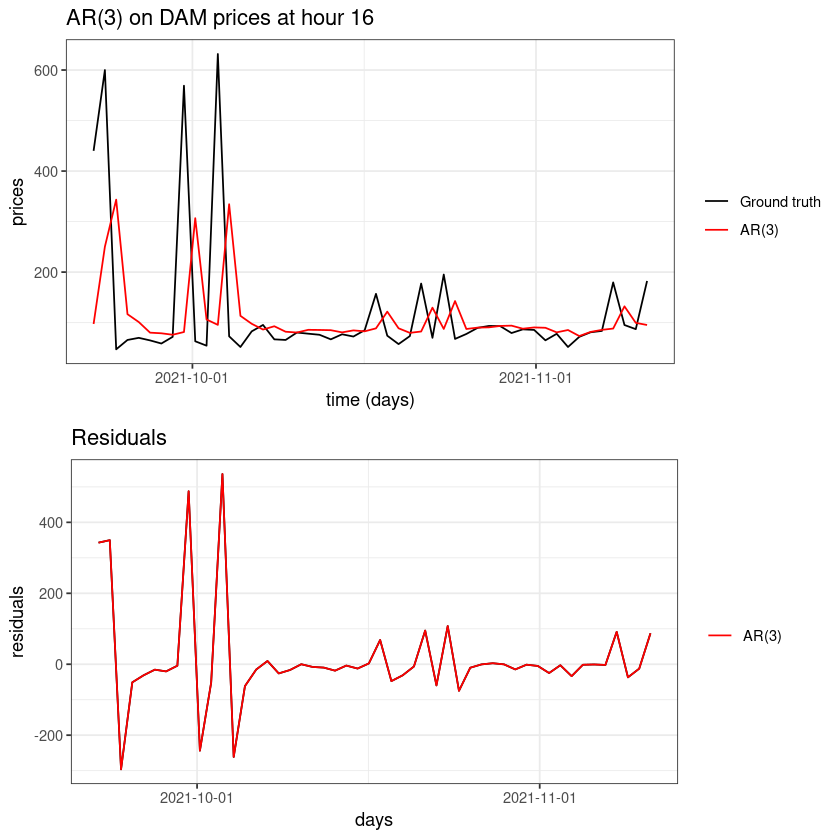

In [14]:
h <- 2021
d1 <- 266
d2 <- 315

hour <- ts(matrix_prices[17,362:dim(matrix_prices)[2]], start=c(2000,362), frequency=365)
model <- Arima(hour, order=c(p,0,0))
fitted1 <- rep(0,length(hour))
for (i in 4:length(hour)){
  fitted1[i] <- as.numeric(model$coef[3])*hour[i-3]+
    as.numeric(model$coef[2])*hour[i-2]+
    as.numeric(model$coef[1])*hour[i-1]+
    as.numeric(model$coef[4])*(1-as.numeric(model$coef[1])-
                                 as.numeric(model$coef[2])-
                                 as.numeric(model$coef[3]))
}
res_fitted1 = hour[4:length(hour)]-fitted1[4:length(hour)]
fitted1 <- fitted1[4:length(hour)]
fitted1 <- ts(fitted1, start=c(2000,365), frequency=365)
mse_arima_train1 <- mean(res_fitted1^2)
abs_fitted1 <- abs(res_fitted1)
mae_ar_test1 <- mean(abs_fitted1[(t+1):(length(hour)-3)])
res_fitted1 <- ts(res_fitted1, start=c(2000,365), frequency=365)
models_arima1 <- ts(data.frame(y1=window(hour, start=c(h,d1), end=c(h,d2), frequency=365),
                              y2=window(fitted1, start=c(h,d1), end=c(h,d2), frequency=365)),
                   start=c(h,d1), end=c(h,d2), frequency=365)
res_fitted_focus1 <- window(res_fitted1, start=c(h,d1), end=c(h,d2))

p1<-autoplot(models_arima1) +
  labs(title = paste("AR(",p,") on DAM prices at hour 16", sep = ""), x = "time (days)", y = "prices", color = "") +
  scale_color_manual(values = c("black", "red"),
                     labels = c("Ground truth", paste("AR(",p,")", sep = ""))) +
  scale_x_continuous(breaks=seq(2021,2022,by=1/12), labels=seq(from = as.Date("2021/01/01"),
                                                               to = as.Date("2022/01/01"),
                                                               by = "month")) +
  theme_bw()
#ses plot residuals
p2 <- autoplot(res_fitted_focus1) +
  labs(title='Residuals', x = "days", y = "residuals", color = "") +
  scale_color_manual(values = c('AR(3)            ' = "red")) +
  geom_line(aes(colour = 'AR(3)            ')) +  # Aggiungo una mappatura del colore
  scale_x_continuous(breaks=seq(2021,2022,by=1/12), labels=seq(from = as.Date("2021/01/01"),
                                                               to = as.Date("2022/01/01"),
                                                               by = "month")) +
  theme_bw()
#grid with forecasts and corresponding residuals
gridExtra::grid.arrange(p1, p2, ncol = 1)


In [ ]:
df_compare <- data.frame(y1=window(fitted, start=c(h,d1), end=c(h,d2), frequency=365),
                         y2=res_fitted_focus,
                         y3=window(fitted1, start=c(h,d1), end=c(h,d2), frequency=365),
                         y4=res_fitted_focus1)
write.csv(df_compare, "errors/ar_compare.csv", row.names = FALSE)


In [16]:
#VAR

In [3]:
library(vars)
t <- 6442
lag_select <- VARselect(t(matrix_prices[,1:t]), lag.max=20,
                        type="const")
#lag_select
optimal_lag <- as.numeric(lag_select$selection["AIC(n)"])
optimal_lag <- 3

Caricamento del pacchetto richiesto: MASS


Caricamento pacchetto: ‘MASS’


I seguenti oggetti sono mascherati da ‘package:fma’:

    cement, housing, petrol


Caricamento del pacchetto richiesto: strucchange

Caricamento del pacchetto richiesto: zoo


Caricamento pacchetto: ‘zoo’


I seguenti oggetti sono mascherati da ‘package:base’:

    as.Date, as.Date.numeric


Caricamento del pacchetto richiesto: sandwich

Caricamento del pacchetto richiesto: urca

Caricamento del pacchetto richiesto: lmtest



Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


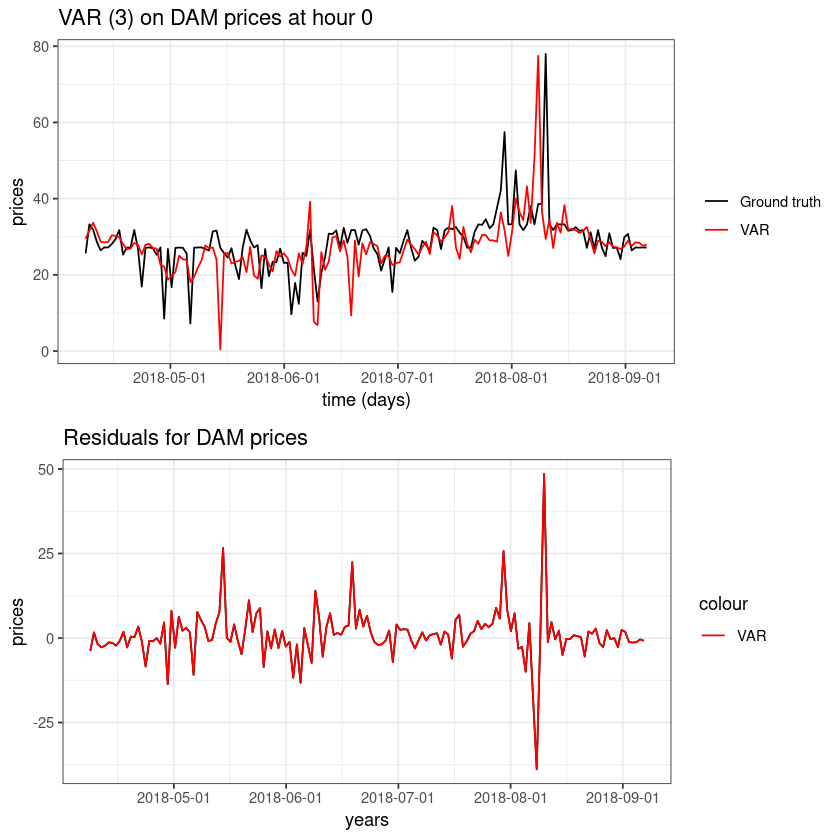

In [4]:
vet <- c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24)
st_var_data <- ts(t(matrix_prices[vet,90:t]), start=c(2000,90), frequency=365)
var_model <- VAR(st_var_data, p = optimal_lag, type = "const")
#summary(var_model)
p <- as.numeric(var_model$p)
K <- as.numeric(var_model$K)
n_par = K*(1+K*p)
coef <- data.frame(matrix(NA, nrow = p, ncol = K))

mae_var_test <- rep(0,24)
mse_var_test <- rep(0,24)
mae_var_train <- rep(0,24)
mse_var_train <- rep(0,24)

var_test <- data.frame(matrix(ncol = 0, nrow = 7938))#######

#Series.1
coef[1,1:K] <- var_model$varresult$Series.1$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.1$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.1$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[1],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour0 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[1] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[1] <- mean(abs_fitted)
mse_var_train[1] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[1] <- mean(abs_fitted)

models_var <- ts(data.frame(y1=ts(matrix_prices[vet[1],(90+optimal_lag):dim(matrix_prices)[2]], start=c(2000,(90+optimal_lag)), frequency=365),
                            y2=st_var), start=c(2000,(90+optimal_lag)), frequency=365)

st_matrix_prices <- ts(matrix_prices[vet[1],], start=c(2000,1), frequency=365)
#plot
p1<-autoplot(models_var) +
  labs(title = paste("VAR (p=",optimal_lag,")"),#Model: MSE_train = ", round(mse_var_train,6), ", MSE_test = ", round(mse_var_test,6)),
       x = "years", y = "prices") +
  scale_color_manual(values = c("black", "red"),
                     labels = c("Ground truth", "VAR")) +
  geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
  theme_bw()
#print(p1)
#ses plot residuals
p2 <- autoplot(res_ts) +
  labs(x = "years", y = "residuals", title = "Residuals for DAM prices") +
  scale_color_manual(values = c("VAR               " = "red")) +
  geom_line(aes(color = "VAR               ")) +  # Aggiungo una mappatura del colore
  geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
  theme_bw()
#print(p2)
#grid with forecasts and corresponding residuals
#gridExtra::grid.arrange(p1, p2, ncol = 1)

#focus giornaliero
h <- 2020
d1 <- 0
d2 <- 130
h <- 2018
d1 <- 100
d2 <- 250
models_var_focus <- ts(data.frame(y1=window(ts(matrix_prices[vet[1],(90+optimal_lag):dim(matrix_prices)[2]], start=c(2000,90+optimal_lag), frequency=365), start=c(h,d1), end=c(h,d2)),
                                  y2=window(st_var, start=c(h,d1), end=c(h,d2))), start=c(h,d1), frequency=365)

res_fitted_focus <- window(res_ts, start=c(h,d1), end=c(h,d2))
p1<-autoplot(models_var_focus) +
  labs(title = paste("VAR (",optimal_lag,") on DAM prices at hour 0",sep=""),
       x = "time (days)", y = "prices", color="") +
  scale_color_manual(values = c("black", "red"),
                     labels = c("Ground truth", "VAR")) +
  scale_x_continuous(breaks=seq(2018,2019,by=1/(12)), labels=seq(from = as.Date("2018/01/01"),
                                                                    to = as.Date("2019/01/01"),
                                                                    by = "month")) +
  #geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
  theme_bw()
#print(p1)
#ses plot residuals
p2 <- autoplot(res_fitted_focus) +
  labs(x = "years", y = "prices", title = "Residuals for DAM prices") +
  scale_color_manual(values = c("VAR                 " = "red")) +
  geom_line(aes(color = "VAR                 ")) +  # Aggiungo una mappatura del colore
  scale_x_continuous(breaks=seq(2018,2019,by=1/(12)), labels=seq(from = as.Date("2018/01/01"),
                                                                    to = as.Date("2019/01/01"),
                                                                    by = "month")) +  
#geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
  theme_bw()
#print(p2)
#grid with forecasts and corresponding residuals
gridExtra::grid.arrange(p1, p2, ncol = 1)


In [5]:

#############################################
#SERIE 2
#############################################

coef[1,1:K] <- var_model$varresult$Series.2$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.2$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.2$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[2],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour1 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[2] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[2] <- mean(abs_fitted)
mse_var_train[2] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[2] <- mean(abs_fitted)

#############################################
#SERIE 3
#############################################

coef[1,1:K] <- var_model$varresult$Series.3$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.3$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.3$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[3],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour2 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[3] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[3] <- mean(abs_fitted)
mse_var_train[3] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[3] <- mean(abs_fitted)

#############################################
#SERIE 4
#############################################

coef[1,1:K] <- var_model$varresult$Series.4$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.4$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.4$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[4],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour3 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[4] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[4] <- mean(abs_fitted)
mse_var_train[4] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[4] <- mean(abs_fitted)

#############################################
#SERIE 5
#############################################

coef[1,1:K] <- var_model$varresult$Series.5$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.5$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.5$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[5],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour4 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[5] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[5] <- mean(abs_fitted)
mse_var_train[5] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[5] <- mean(abs_fitted)

#focus giornaliero
# h <- 2021
# d1 <- 266
# d2 <- 315
# models_var_focus <- ts(data.frame(y1=window(ts(matrix_prices[vet[5],], start=c(2000,1), frequency=365), start=c(h,d1), end=c(h,d2)),
#                                   y2=window(st_var, start=c(h,d1), end=c(h,d2))), start=c(h,d1), frequency=365)

# res_fitted_focus <- window(res_fitted, start=c(h,d1), end=c(h,d2))


# p1<-autoplot(models_var_focus) +
#   labs(title = paste("VAR (",optimal_lag,") on DAM prices at hour 4",sep=""),
#        x = "time (days)", y = "prices", color="") +
#   scale_color_manual(values = c("black", "red"),
#                      labels = c("Ground truth", "VAR")) +
#   scale_x_continuous(breaks=seq(2021,2022,by=1/(12)), labels=seq(from = as.Date("2021/01/01"),
#                                                                  to = as.Date("2022/01/01"),
#                                                                  by = "month")) +
#   #geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
#   theme_bw()
# #print(p1)
# #ses plot residuals
# p2 <- autoplot(res_fitted_focus) +
#   labs(x = "years", y = "prices", title = "Residuals for DAM prices") +
#   scale_color_manual(values = c("VAR(7)               " = "red")) +
#   geom_line(aes(color = "VAR(7)               ")) +  # Aggiungo una mappatura del colore
#   #geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
#   theme_bw()
# #print(p2)
# #grid with forecasts and corresponding residuals
# gridExtra::grid.arrange(p1, p2, ncol = 1)

#############################################
#SERIE 6
#############################################

coef[1,1:K] <- var_model$varresult$Series.6$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.6$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.6$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[6],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour5 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[6] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[6] <- mean(abs_fitted)
mse_var_train[6] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[6] <- mean(abs_fitted)

#############################################
#SERIE 7
#############################################

coef[1,1:K] <- var_model$varresult$Series.7$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.7$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.7$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[7],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour6 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[7] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[7] <- mean(abs_fitted)
mse_var_train[7] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[7] <- mean(abs_fitted)

#############################################
#SERIE 8
#############################################

coef[1,1:K] <- var_model$varresult$Series.8$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.8$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.8$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[8],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour7 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[8] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[8] <- mean(abs_fitted)
mse_var_train[8] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[8] <- mean(abs_fitted)

#############################################
#SERIE 9
#############################################

coef[1,1:K] <- var_model$varresult$Series.9$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.9$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.9$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[9],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour8 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[9] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[9] <- mean(abs_fitted)
mse_var_train[9] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[9] <- mean(abs_fitted)

#############################################
#SERIE 10
#############################################

coef[1,1:K] <- var_model$varresult$Series.10$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.10$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.10$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[10],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour9 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[10] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[10] <- mean(abs_fitted)
mse_var_train[10] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[10] <- mean(abs_fitted)

#############################################
#SERIE 11
#############################################

coef[1,1:K] <- var_model$varresult$Series.11$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.11$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.11$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[11],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour10 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[11] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[11] <- mean(abs_fitted)
mse_var_train[11] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[11] <- mean(abs_fitted)

#############################################
#SERIE 12
#############################################

coef[1,1:K] <- var_model$varresult$Series.12$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.12$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.12$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[12],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour11 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[12] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[12] <- mean(abs_fitted)
mse_var_train[12] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[12] <- mean(abs_fitted)

#############################################
#SERIE 13
#############################################

coef[1,1:K] <- var_model$varresult$Series.13$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.13$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.13$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[13],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour12 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[13] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[13] <- mean(abs_fitted)
mse_var_train[13] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[13] <- mean(abs_fitted)

#############################################
#SERIE 14
#############################################

coef[1,1:K] <- var_model$varresult$Series.14$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.14$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.14$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[14],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour13 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[14] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[14] <- mean(abs_fitted)
mse_var_train[14] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[14] <- mean(abs_fitted)

#############################################
#SERIE 15
#############################################

coef[1,1:K] <- var_model$varresult$Series.15$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.15$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.15$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[15],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour14 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[15] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[15] <- mean(abs_fitted)
mse_var_train[15] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[15] <- mean(abs_fitted)

#############################################
#SERIE 16
#############################################

coef[1,1:K] <- var_model$varresult$Series.16$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.16$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.16$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[16],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour15 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[16] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[16] <- mean(abs_fitted)
mse_var_train[16] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[16] <- mean(abs_fitted)

#############################################
#SERIE 17
#############################################

coef[1,1:K] <- var_model$varresult$Series.17$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.17$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.17$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[17],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour16 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[17] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[17] <- mean(abs_fitted)
mse_var_train[17] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[17] <- mean(abs_fitted)


# #focus giornaliero
# h <- 2020
# d1 <- 143
# #d1 <- 200
# d2 <- d1+150
# models_var_focus <- ts(data.frame(y1=window(ts(matrix_prices[vet[17],(90+optimal_lag):dim(matrix_prices)[2]], start=c(2000,90+optimal_lag), frequency=365), start=c(h,d1), end=c(h,d2)),
#                                   y2=window(st_var, start=c(h,d1), end=c(h,d2))), start=c(h,d1), frequency=365)

# res_fitted_focus <- window(res_ts, start=c(h,d1), end=c(h,d2))

# p1<-autoplot(models_var_focus) +
#   labs(title = paste("VAR (",optimal_lag,") on DAM prices at hour 17",sep=""),
#        x = "time (days)", y = "prices", color="") +
#   scale_color_manual(values = c("black", "red"),
#                      labels = c("Ground truth", "VAR")) +
#   scale_x_continuous(breaks=seq(h,h+1,by=1/(12)), labels=seq(from = as.Date("2021/01/01"),
#                                                                  to = as.Date("2022/01/01"),
#                                                                  by = "month")) +
#   #geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
#   theme_bw()
# #print(p1)
# #ses plot residuals
# p2 <- autoplot(res_fitted_focus) +
#   labs(x = "years", y = "prices", title = "Residuals for DAM prices") +
#   scale_color_manual(values = c("VAR(7)               " = "red")) +
#   geom_line(aes(color = "VAR(7)               ")) +  # Aggiungo una mappatura del colore
#   #geom_vline(xintercept=2017.6, linetype = "dashed", color = "black") +
#   theme_bw()
# #print(p2)
# #grid with forecasts and corresponding residuals
# gridExtra::grid.arrange(p1, p2, ncol = 1)

#############################################
#SERIE 18
#############################################

coef[1,1:K] <- var_model$varresult$Series.18$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.18$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.18$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[18],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour17 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[18] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[18] <- mean(abs_fitted)
mse_var_train[18] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[18] <- mean(abs_fitted)

#############################################
#SERIE 19
#############################################

coef[1,1:K] <- var_model$varresult$Series.19$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.19$coefficients[((l-1)*K+1):(l*K)]
}
coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.19$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[19],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour18 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[19] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[19] <- mean(abs_fitted)
mse_var_train[19] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[19] <- mean(abs_fitted)

#############################################
#SERIE 20
#############################################

coef[1,1:K] <- var_model$varresult$Series.20$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.20$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.20$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[20],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour19 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[20] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[20] <- mean(abs_fitted)
mse_var_train[20] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[20] <- mean(abs_fitted)

#############################################
#SERIE 21
#############################################

coef[1,1:K] <- var_model$varresult$Series.21$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.21$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.21$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[21],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour20 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[21] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[21] <- mean(abs_fitted)
mse_var_train[21] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[21] <- mean(abs_fitted)

#############################################
#SERIE 22
#############################################

coef[1,1:K] <- var_model$varresult$Series.22$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.22$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.22$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[22],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour21 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[22] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[22] <- mean(abs_fitted)
mse_var_train[22] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[22] <- mean(abs_fitted)

#############################################
#SERIE 23
#############################################

coef[1,1:K] <- var_model$varresult$Series.23$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.23$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.23$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[23],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour22 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[23] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[23] <- mean(abs_fitted)
mse_var_train[23] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[23] <- mean(abs_fitted)

#############################################
#SERIE 24
#############################################

coef[1,1:K] <- var_model$varresult$Series.24$coefficients[1:K]
for (l in 2:p){
  coef[l,1:K] <- var_model$varresult$Series.24$coefficients[((l-1)*K+1):(l*K)]
}
#coef
var_fitted <- rep(NA,dim(matrix_prices)[2])
sum <- NA
for (time in (90+optimal_lag-1):(dim(matrix_prices)[2]-1)){
  sum <- var_model$varresult$Series.24$coefficients[n_par/K]
  for (k in 1:p){
    for (j in 1:K){
      sum <- sum + coef[k,j]*matrix_prices[vet[j],time-k+1]
    }
  }
  var_fitted[time+1] <- sum
}
var_fitted <- var_fitted[(90+optimal_lag):dim(matrix_prices)[2]]
res_fitted <- matrix_prices[vet[24],(90+optimal_lag):dim(matrix_prices)[2]] - var_fitted
st_var <- ts(var_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
res_ts <- ts(res_fitted, start=c(2000,(90+optimal_lag)), frequency=365)
var_test$Hour23 <- st_var
#forecast <- var_fitted[(t+1):dim(matrix_prices)[2]]
#fitted <- var_fitted[1:t]
#fitted <- ts(fitted, start=c(2000,1), frequency=365)
#forecast <- ts(forecast, end=c(2021,365), frequency=365)
mse_var_test[24] <- mean(window(res_ts, start=c(2017,237))^2)
abs_fitted <- abs(window(res_ts, start=c(2017,237)))
mae_var_test[24] <- mean(abs_fitted)
mse_var_train[24] <- mean(window(res_ts, end=c(2017,236))^2)
abs_fitted <- abs(window(res_ts, end=c(2017,236)))
mae_var_train[24] <- mean(abs_fitted)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02875475,0.001989471,0.02723280,0.18600017,0.04892226,0.058058223,-0.005749955,-0.012224153,-0.002233520,-0.005992666,⋯,0.005386796,-0.017423892,0.0010263183,0.004535868,-0.008042808,0.0056277904,0.0233635001,0.016765799,0.009599366,0.220093569
0.01383835,-0.020014051,0.07460880,0.00294760,0.02020682,-0.007687045,0.013941790,-0.018959282,0.003296480,0.006683410,⋯,-0.005892309,0.008700773,-0.0048558219,-0.005599275,0.002724733,-0.0002331268,0.0005019661,0.010283435,0.009902626,0.002003039
-0.01689431,-0.005624277,0.03702029,0.08650045,0.05819400,0.014172715,-0.007643407,0.005781633,-0.006140403,-0.001818754,⋯,0.008217669,0.001133216,-0.0006381088,-0.008989383,0.022132841,-0.0117889800,0.0003361443,-0.003793835,-0.005491718,-0.005563113


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.006347973,0.01713633,-0.02408038,0.18405783,0.09194862,0.02215693,-0.009640985,-0.0002648743,-0.007446761,-0.0142506140,⋯,0.003937605,-0.0142318457,0.0046737774,0.006734344,-0.006358727,0.0009010647,0.019368848,0.008059541,0.034937485,0.114068230
0.010472090,-0.02116323,0.01214112,0.20529433,-0.05112214,0.02699177,-0.002594927,0.0106979213,-0.011554221,-0.0003245709,⋯,-0.003075399,0.0001256702,-0.0051404371,0.003026810,-0.009516339,0.0023589275,0.010182840,0.003538772,0.009334729,0.005939905
-0.006644013,0.00395125,0.01506060,0.09024209,0.02082310,0.02954266,-0.016488426,0.0212685156,-0.006780245,-0.0011272476,⋯,0.003341824,0.0051078942,-0.0000163814,-0.005423472,0.011840300,-0.0116053255,-0.005218962,0.004115730,0.013179970,-0.009008803


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.07086944,-0.057769879,-0.000362295,0.12127007,0.07783587,0.076389745,-0.05472080,0.218620328,0.01250622,-0.0768404979,⋯,-2.201566e-02,-0.0488660619,0.027270315,0.0107925379,0.042298587,0.0370403352,0.131665857,0.1073070184,0.10100013,-0.03855194
-0.02742272,-0.009162164,-0.026409175,0.12725158,0.17400874,-0.161417877,-0.03502547,0.063052165,-0.04415207,0.0131269290,⋯,-1.857190e-02,0.0000295779,-0.001819195,-0.0096530815,0.033169846,0.0008948934,0.007301749,-0.0156252195,0.06881270,-0.02140116
-0.01795493,0.057644834,0.061199270,-0.01676487,0.12265119,-0.004764329,0.01742653,0.009917083,-0.02611283,-0.0002866165,⋯,8.427811e-06,0.0267326357,-0.030716336,0.0002484274,-0.004472918,-0.0050222141,-0.017706444,0.0008597338,-0.06983762,0.16222628


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1683661,0.03893835,-0.13342472,0.001656177,-0.07285987,0.06335694,-0.11000714,-0.06557973,0.08264764,-0.06613399,⋯,0.022498097,0.007448489,0.07971780,-0.009333313,0.09971800,-0.030570626,0.058938525,0.25046737,0.23575706,0.17332461
-0.1256307,0.13273223,-0.10012603,-0.141053910,0.27314944,-0.14349510,0.02161545,-0.02730404,-0.07400555,0.02177770,⋯,0.028552814,0.012863819,-0.01408923,0.033812592,-0.01975624,0.004949093,0.001121872,0.04561255,-0.04473148,-0.09822187
0.1350439,-0.11487912,0.08098201,0.013477890,-0.19240697,0.05109271,-0.01719353,-0.08247650,0.07073107,0.03397396,⋯,0.006075228,0.031271437,-0.01214400,-0.034049357,-0.01493030,-0.001753015,0.039768822,-0.07484664,0.06683055,0.07866883


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.04420742,0.08508220,-0.216174231,0.248431310,-0.13265591,-0.06090335,-0.12121893,-0.05361310,0.0513288168,-0.03755205,⋯,0.038378453,0.04540396,0.076624619,-0.001685707,0.098160817,-0.0667715073,0.04297976,0.250023186,0.24076608,0.1197477636
-0.08229606,0.07745737,-0.003344383,-0.133795683,0.20006248,-0.10570605,0.01202615,-0.03428878,-0.0813974228,0.02473017,⋯,0.007331564,0.07269725,-0.055008006,0.034130727,-0.005117775,0.0136016646,-0.02481642,-0.002499576,0.06110983,0.0204940666
0.05434446,-0.03998704,-0.027045653,0.006569287,-0.09762268,0.05827173,-0.01711532,-0.03829129,0.0006285964,0.03482903,⋯,0.012278426,0.02191396,0.002767035,-0.044659167,-0.023405436,0.0008042915,0.01546661,-0.074247939,0.16402730,-0.0009881114


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.0003698295,0.02708170,-0.1926876,0.37236104,-0.17980470,-0.12139589,-0.0894793422,-0.06696612,0.045903457,-0.07160350,⋯,0.001194385,0.09594297,0.131092919,-0.008649553,0.093065112,-0.09123490,0.009065307,0.23255898,0.2617643,0.086505602
-0.0776321998,0.08409122,-0.2116071,-0.08736788,0.23424252,-0.11313264,0.0216070441,-0.05957521,-0.085381983,0.05874755,⋯,0.006558329,0.07631144,-0.042169239,0.021738513,-0.001615166,0.01088189,-0.001401918,-0.01767020,0.1270604,0.065186406
0.1182385316,-0.08103567,-0.0397555,-0.02187845,-0.03883913,0.08864842,0.0004332848,-0.08001699,0.003924359,0.04155997,⋯,-0.009381119,0.02704279,-0.008191886,-0.041499446,-0.021880038,0.01190478,0.010060806,-0.05834598,0.1400717,0.002206875


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.01506037,-0.0004879465,-0.07454422,0.36758675,-0.1091064,-0.17855666,-0.07220598,-0.04605556,-0.003450171,-0.03676190,⋯,0.08517787,0.12576431,0.1108000484,-0.001583305,0.09065347,-0.100486232,0.06156552,0.24914959,0.22529577,-0.02732605
-0.03967164,0.0911539503,-0.12055122,-0.06801533,0.1328800,-0.03264048,0.06710334,-0.03160632,-0.097587840,0.02181388,⋯,-0.01917352,0.05716721,-0.0258503506,0.015920112,-0.01597092,0.010911683,-0.02084330,0.01946085,0.06137489,0.10186734
0.18533566,-0.0179415948,-0.10668708,-0.05026134,0.1049952,-0.05094742,-0.01075858,-0.06956881,-0.025793466,0.03752595,⋯,0.01381312,0.03598298,0.0007654919,-0.034557761,-0.01908982,-0.005882716,-0.03125485,-0.04531889,0.06304181,-0.01800833


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.01164620,-0.08504592,-0.327957770,0.52138167,0.1023005,-0.04109570,-0.04974370,0.02856561,0.05565032,-0.110312318,⋯,-0.045616540,-0.01520450,0.04236263,0.049464821,0.22323266,0.043244436,0.042113183,0.10966541,0.162758226,0.122706906
-0.09491179,0.03305992,0.001196704,-0.03365991,0.1497866,0.02166405,0.11381442,-0.05745778,-0.01534673,0.006426462,⋯,0.002337706,-0.06661089,-0.07599300,0.078612188,0.08204508,0.006781081,0.018171198,-0.09356178,0.009349031,0.089686038
-0.01710438,0.01470769,0.055012911,0.25965718,-0.1658385,0.13873792,-0.03127783,-0.04629518,-0.02037306,0.023370209,⋯,0.037519900,0.04258702,-0.02727824,0.006615524,0.05000773,-0.023296632,0.008765376,-0.03860613,0.015329844,-0.007475755


In [16]:
mean(mse_var_test)
mean(mse_var_train)
mean(mae_var_test)
mean(mae_var_train)

[1] 7958.053

[1] 7378.609

[1] 34.02592

[1] 35.04439

In [17]:
for (i in 1:24){
    mse_var_test[i] <- round(mse_var_test[i], digits = 1)
    mae_var_test[i] <- round(mae_var_test[i], digits = 3)
    mse_var_train[i] <- round(mse_var_train[i], digits = 1)
    mae_var_train[i] <- round(mae_var_train[i], digits = 3)
    }

In [19]:
mse_var_train[1:20]

[1]   601.7   518.1   293.4   232.0   291.8   431.0  2820.4  3212.0  4496.8
[10]  6103.0  9130.1 12197.8 12382.5 13733.3 14429.6 14554.9 17530.5 21791.0
[19] 13795.1 10413.1

In [20]:
data <- data.frame(Vector1 = mse_var_test,
                   Vector2 = mae_var_test,
                   Vector3 = mse_var_train,
                   Vector4 = mae_var_train)

# Scrittura del data frame in un file CSV
write.csv(data, "../errors/errori_var.csv", row.names = FALSE)

In [13]:
vvv <- window(st_var, start=c(2017,241), frequency=365)

In [15]:
testt <- data.frame(Vector1 = vvv)
write.csv(testt, '../plot/compare/test_var.csv', row.names=FALSE)

In [9]:
8030-1588

[1] 6442

In [10]:
31*5+30*2+26

[1] 241

In [16]:
st_var

A Time Series:
   [1]  34.2758869  36.2399493  32.3281765  32.6161020  33.0041121  34.9068953
   [7]  35.6684774  36.8794513  40.0111540  40.0774089  45.4772597  57.4501804
  [13]  77.2988530  48.0112089 140.3709672  79.3947201  74.7997574  46.5864400
  [19]  50.4694237  42.5290848  41.5096430  52.3552587  51.8726495  47.6076724
  [25]  72.7807914  41.6757717  25.5345665  26.5172039  33.0896140  31.9268619
  [31]  33.4185297  32.7500244  41.1490015  34.4377476  39.3744129  33.7902637
  [37]  33.4684375  35.5105489  26.4135244  83.4038332  55.4542640  31.1391034
  [43]  40.3610972  36.6361293  30.7269602  36.4169464  39.3849412  38.8457637
  [49]  42.1706919  43.2479248  39.4510289  43.3650452  44.4734829  42.3321398
  [55]  44.5743889  40.8581769  39.9215480  37.9370034  32.5584483  36.0892844
  [61]  46.5314149  46.6186583  53.2881880  47.1814915  46.0292010  67.2581102
  [67]  35.8275875  59.5688385  54.7930959  61.1662007  59.5261721  52.6874548
  [73]  61.1248742  40.0307348  61.6765466  78.9526110  52.9037178  57.8481831
  [79]  59.4668753  66.4607804  66.1410630  68.2663176  84.7796904  58.3161076
  [85]  64.6370219  34.2115058  65.2117407  66.8886390  51.3796099  63.1265754
  [91]  71.3536322  64.6962622  58.0872422  59.0867118  62.5665995  55.2078947
  [97]  65.0523148  58.2095781  58.9836175  66.1054603  74.0362299  54.3408306
 [103]  84.9982635  65.8287753  54.1133284  66.3131615  56.6462811  56.4377433
 [109]  72.2575871  81.0163158  26.9115194  70.3984997  57.8415978  63.9562777
 [115]  57.7385487  51.4711646  74.2451045  73.1989673  50.0339287  70.6024924
 [121]  66.7601513  56.8154008  59.4128334  87.3773644  83.0634335  69.5773574
 [127]  74.9310026  61.8094812  68.4265735  64.8343843  90.1683638 114.2612575
 [133]  70.9180210  65.9118740  80.4039976 115.3930645  85.3135462  92.2935245
 [139] 100.2496909  56.0311391  73.3078581 110.2852770 124.6116758 131.5466219
 [145] 129.5823604 183.7355577  92.0428031  89.3381451  60.4526976  59.8047710
 [151]  70.0057236  68.1139212  87.8762335  74.7730847  82.8983943  76.1993291
 [157]  86.0313713 111.6096040 112.2953387  98.8369742  75.8306270  87.7848504
 [163]  83.5872738 116.3840385 110.5665431 122.1037468 100.0089603  66.8670172
 [169]  89.3174172  88.0537671  74.4116732  86.5266041  92.5643585  90.7474582
 [175]  82.6457345  80.7436104  77.9187315 103.4492988 107.4237893 112.7093845
 [181]  94.3385211 103.6017393  90.1444386  91.3646600  79.3395268 119.0350659
 [187] 164.8668246 156.4989303 165.8736413 115.8858929  76.6414171 113.7180086
 [193] 107.9880551 108.7186804 138.7189774 120.0541099  97.8942251 117.9038636
 [199] 107.1418311 112.7202855 126.0941549 230.4834685 242.4275586 185.2822179
 [205] 182.7721960 178.0494392 190.9524855 232.0897097 162.9114442 106.5357079
 [211]  93.3534753  91.8675650  95.6531714  99.9206763 125.0118356 106.6851769
 [217]  83.7102482  97.5736092 107.2748657 157.7524081  99.9294059 111.1430331
 [223]  91.3864721  80.2890574 105.6838446 101.3050519  99.9027484 106.8561340
 [229] 111.0128507 106.7507901 111.1373746 104.6965017 121.0767368 138.0074166
 [235] 137.6266296 111.4901104 123.8468493  85.1841900 117.0808874 102.6387087
 [241] 118.1925067 145.0829986 133.0447070  92.5994185 124.4173757 145.8888858
 [247] 132.5214766 106.3035593 123.0982107 107.4402404 128.1315539 129.4444379
 [253] 116.9958336 125.1296306 147.2671207 164.3484182 163.6994503 123.5506356
 [259] 168.1263024 109.5354922 125.1750629 124.9905491  93.6159597 145.7565744
 [265] 113.9907970 139.7848871 140.7023708 134.4586853 111.4232977 137.4767308
 [271] 110.6375661 138.1993154 124.7999796 115.0365307 127.3756595 125.2092934
 [277] 128.4432466 131.0512230 101.9774674  97.0095617 101.0683505  94.0437557
 [283]  92.2405060  88.1747461  75.0479774  88.5375034  85.3755335  98.5386194
 [289] 103.1262909  90.1613864  90.0680840  84.9593855  92.9302018 121.5915057
 [295] 131.7712963 129.3296460 138.3323995 165.7290408 139.4550592 110.0634056
 [301] 115.0049797 110.0825632 109.